<a href="https://colab.research.google.com/github/thursdaydreaming/whitescan/blob/main/Spherical_k_means_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install pandas
!pip install sklearn
!pip install konlpy
import pandas as pd

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
import pickle
import re
import konlpy
import nltk
import numpy as np

In [23]:
#데이터 불러오기

clu = pd.read_csv("drive/MyDrive/Sheet1.csv", sep=',')

In [24]:
def clean_korean_documents(documents):
    #텍스트 정제 (HTML 태그 제거)
    # for i, document in enumerate(documents):
    #     document = BeautifulSoup(document, 'html.parser').text 
    #     documents[i] = document

    #텍스트 정제 (특수기호 제거)
    for i, document in enumerate(documents):
        document = re.sub(r'[^ ㄱ-ㅣ가-힣]', '', document) #특수기호 제거, 정규 표현식
        documents[i] = document

    #텍스트 정제 (형태소 분석)
    for i, document in enumerate(documents):
        okt = konlpy.tag.Okt()
        clean_words = []
        for word in okt.pos(document, stem=True): #어간 추출
            if word[1] in ['Noun', 'Verb', 'Adjective']: #명사, 동사, 형용사
                clean_words.append(word[0])
        document = ' '.join(clean_words)
        documents[i] = document

    #텍스트 정제 (불용어 제거)
    df = pd.read_csv('https://raw.githubusercontent.com/cranberryai/todak_todak_python/master/machine_learning_text/clean_korean_documents/korean_stopwords.txt', header=None)
    df[0] = df[0].apply(lambda x: x.strip())
    stopwords = df[0].to_numpy()
    nltk.download('punkt')
    for i, document in enumerate(documents):
        clean_words = [] 
        for word in nltk.tokenize.word_tokenize(document): 
            if word not in stopwords: #불용어 제거
                clean_words.append(word)
        documents[i] = ' '.join(clean_words)  

    return documents

In [25]:
clu1 = clu['키워드']
x_data = clean_korean_documents(clu1) #텍스트 정제
print(x_data)

#vectorizing
transformer = TfidfVectorizer()
transformer.fit(x_data)
x_data_count = transformer.transform(x_data) #단어 카운트 가중치

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
0                 원피스
1       써스데이 아일랜드 원피스
2              여름 원피스
3                블라우스
4                남자 티
            ...      
2995             프라이머
2996          아이 프라이머
2997          아이 프라이머
2998     맥 라이트 풀 프라이머
2999             프라이머
Name: 키워드, Length: 3000, dtype: object


In [26]:
# K-means로 3개 군집으로 문서 군집화시키기
from sklearn.cluster import KMeans

# 인자 조절은 이곳에서
kmeans = KMeans(n_clusters=3, max_iter=10000, random_state=42)

# 비지도 학습이니 feature로만 학습시키고 예측
cluster_label = kmeans.fit_predict(x_data_count)

# 군집화한 레이블값들을 document_df 에 추가하기
clu['cluster_label'] = cluster_label
print(clu.sort_values(by=['cluster_label']))

# 변환 파일 내보내기
# clu.to_csv('drive/MyDrive/new_label2.csv')

       카테고리          키워드  cluster_label
0     의류/잡화          원피스              0
1864     음식  통밀 김치 어묵 우동              0
258   의류/잡화        레 원피스              0
1865     음식     통밀 김치 우동              0
1866     음식     통밀 알밥 우동              0
...     ...          ...            ...
1081     음식         미역냉국              2
1082     음식          미역국              2
1083     음식        무 된장국              2
1085     음식       생 잇다 국              2
2999    화장품         프라이머              2

[3000 rows x 3 columns]


In [27]:
# Spherical k-means 방식 적용

!pip install soyclustering

In [33]:
from soyclustering import SphericalKMeans

spherical_kmeans = SphericalKMeans(
    n_clusters=3,
    max_iter=10,
    verbose=1,
    init='similar_cut',
    sparsity='minimum_df',
    minimum_df_factor=0.05
)

labels = spherical_kmeans.fit_predict(x_data_count)

# 군집화한 레이블값들을 document_df 에 추가하기
clu['cluster_label_2'] = labels
print(clu.sort_values(by=['cluster_label_2']))

clu.to_csv('drive/MyDrive/new_label3.csv')

initialization_time=0.005026 sec, sparsity=0.000765
n_iter=1, changed=43, inertia=2953.143, iter_time=0.015 sec, sparsity=0.208
n_iter=2, changed=41, inertia=2742.639, iter_time=0.010 sec, sparsity=0.212
n_iter=3, changed=109, inertia=2727.426, iter_time=0.010 sec, sparsity=0.215
n_iter=4, changed=139, inertia=2698.272, iter_time=0.010 sec, sparsity=0.217
n_iter=5, changed=81, inertia=2682.933, iter_time=0.010 sec, sparsity=0.218
n_iter=6, changed=50, inertia=2679.600, iter_time=0.011 sec, sparsity=0.219
n_iter=7, changed=53, inertia=2676.392, iter_time=0.011 sec, sparsity=0.221
n_iter=8, changed=31, inertia=2672.695, iter_time=0.010 sec, sparsity=0.223
n_iter=9, changed=34, inertia=2671.617, iter_time=0.010 sec, sparsity=0.224
n_iter=10, changed=24, inertia=2669.871, iter_time=0.010 sec, sparsity=0.225
       카테고리                 키워드  cluster_label  cluster_label_2
0     의류/잡화                 원피스              0                0
2136    화장품  아이 오페 슈퍼 바 이탈 멀다 젼              2           

In [37]:
from soyclustering import proportion_keywords

centers = kmeans.cluster_centers_

keywords = proportion_keywords(
    centers,
    labels=labels,
    index2word=x_data)

# 군집으로 키워드 추출
print(keywords)

[[('감자 옹심이', 1.0), ('열무 비빔국수', 1.0), ('빈폴 레이디스', 1.0), ('남자 퍼', 1.0), ('산자', 1.0), ('카시오 시계', 1.0), ('여성 점프수트', 1.0), ('나이키 여성 운동화', 1.0), ('컨버 스타 이크', 1.0), ('여름 모자', 1.0), ('석쇠 돼지 불고기', 1.0), ('불고기', 1.0), ('산채 비빔밥', 1.0), ('삼선 비빔밥', 1.0), ('샐러드 김밥', 1.0), ('수정과', 1.0), ('컨', 1.0), ('체크 원피스', 1.0), ('여성 여름 블라우스', 1.0), ('레코 브', 1.0), ('멜빵 바지', 1.0), ('나이키 레깅스', 1.0), ('뉴발란스 샌들', 1.0), ('남성 운동화', 1.0), ('웨 샌들', 1.0), ('샤넬 지갑', 1.0), ('칼린 가방', 1.0), ('토끼 크다 록스', 1.0), ('셀린느 트리 오페', 1.0), ('해물 수제비', 1.0), ('오징어 볶음', 1.0), ('주꾸미 볶음', 1.0), ('도토리묵 무치다', 1.0), ('구기자 차', 1.0), ('초 간장', 1.0), ('왕 갈비탕', 1.0), ('여름 자켓', 1.0), ('전어 무치다', 1.0), ('땀복', 1.0), ('팩', 1.0), ('바바라 샌들', 1.0), ('우거지 해장국', 1.0), ('고구마 튀김', 1.0), ('메종 마르지 엘라 가방', 1.0), ('막 양산', 1.0), ('남자 슬랙스', 1.0), ('여성 여름 잠옷', 1.0), ('샤넬 샌들', 1.0), ('항아리 수제비', 1.0), ('파자마', 1.0), ('소고기 샤브샤브', 1.0), ('트렁크 팬티', 1.0), ('콩잎 장아찌', 1.0), ('솔트 워터 샌들', 1.0), ('김치 만두', 0.9995391515652737), ('강된장', 0.9962180723195845), ('베네통', 0.9917128925668207

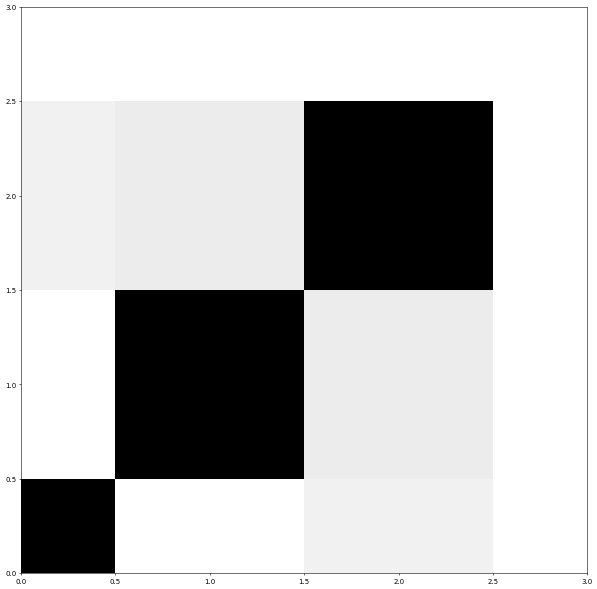

In [38]:
from soyclustering import visualize_pairwise_distance

# visualize pairwise distance matrix
fig = visualize_pairwise_distance(centers, max_dist=.7, sort=True)

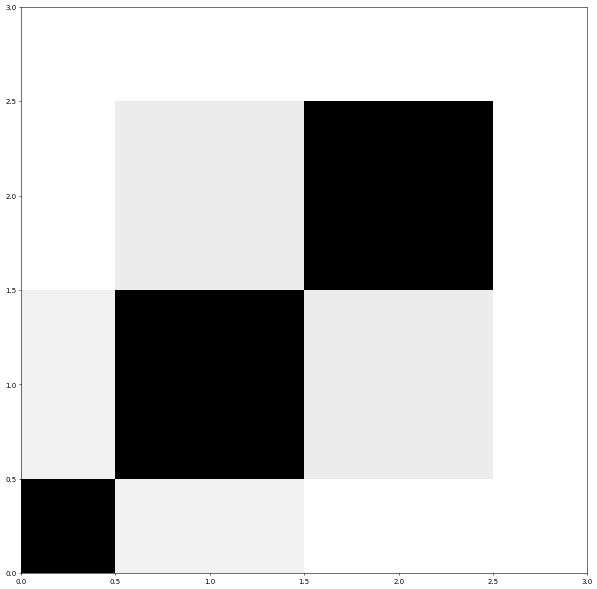

In [39]:
from soyclustering import merge_close_clusters

group_centers, groups = merge_close_clusters(centers, labels, max_dist=.5)
fig = visualize_pairwise_distance(group_centers, max_dist=.7, sort=True)